In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pickle, os
import pandas as pd
from tqdm import tqdm 

## Load Important Function

In [2]:
class Data:
    def __init__(self, array_list):
        self.array_list = array_list

    def save(self, filename):
        with open(filename, 'wb') as f:
            pickle.dump(self.array_list, f)

    @classmethod
    def load(cls, filename):
        with open(filename, 'rb') as f:
            array_list = pickle.load(f)
        return cls(array_list)

In [3]:
def omega2cistrans(omega):
    """Converts a sequence of float omega angles (in degrees) to an array of ints: 0 cis and 1 trans."""
    
    shifted_omega = (omega + 90.0) % 360.0 - 90.0 # shift into (-90, 270) range to avoid periodic boundaries
    
    cistrans = np.where(shifted_omega > 90.0, 1, 0).astype(int)
    return cistrans

In [4]:
import numpy as np
from tqdm import tqdm

def calculate_trans_p(traj):
    """
    Calculates the cumulative trans population and standard error per timepoint.
    
    Parameters
    ----------
    traj : np.ndarray
        A 2D array of shape (timesteps, residues), where values are either 0 (cis) or 1 (trans).

    Returns
    -------
    trans_population : np.ndarray
        Running trans population per residue (same shape as input).
    
    trans_population_err : np.ndarray
        Standard error of trans population (same shape).
    """

    trans_population = np.zeros_like(traj, dtype=float)
    trans_population_err = np.zeros_like(traj, dtype=float)
    n_res = traj.shape[1]
    n_time = traj.shape[0]

    for res_idx in tqdm(range(n_res), desc="Calculating trans populations", ncols=100):
        trans_count = 0

        for j in range(n_time):
            val = traj[j, res_idx]

            if val == 1:
                trans_count += 1

            p = trans_count / (j + 1)
            trans_population[j, res_idx] = p
            trans_population_err[j, res_idx] = np.sqrt(p * (1 - p) / (j + 1))

    print('Trans population shape:', trans_population.shape)
    print('Trans population error shape:', trans_population_err.shape)
    return trans_population, trans_population_err


## The Trans Population overtime Plot

In [5]:
omega_all_state = []
state_num = 3
for i in range(state_num):
    omega_state = np.array(Data.load(f'omega_data/omegas_state{i}.pkl').array_list)
    omega_all_state.append(omega_state)

omega_all_state = np.array(omega_all_state)
omega_all_state.shape


(3, 337514, 3)

In [6]:
ntraj = len(omega_all_state)
print('np.array(omega_all_state).shape', np.array(omega_all_state).shape)

cistrans = omega2cistrans(omega_all_state)
print('cistrans.shape', cistrans.shape)

cistrans[0, :10, :]

np.array(omega_all_state).shape (3, 337514, 3)
cistrans.shape (3, 337514, 3)


array([[1, 1, 0],
       [1, 1, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0]])

In [7]:
trans_all_population = []
trans_all_population_err = []
state_num = 3

for state in range(state_num):
    traj = cistrans[state]
    trans_population, trans_population_err = calculate_trans_p(traj)
    
    trans_all_population.append(trans_population)
    trans_all_population_err.append(trans_population_err)

trans_all_population = np.array(trans_all_population)
trans_all_population_err = np.array(trans_all_population_err)

print('trans_all_population.shape', trans_all_population.shape)
print('trans_all_population_err.shape', trans_all_population_err.shape)

Calculating trans populations: 100%|██████████████████████████████████| 3/3 [00:01<00:00,  1.78it/s]


Trans population shape: (337514, 3)
Trans population error shape: (337514, 3)


Calculating trans populations: 100%|██████████████████████████████████| 3/3 [00:01<00:00,  1.71it/s]


Trans population shape: (337514, 3)
Trans population error shape: (337514, 3)


Calculating trans populations: 100%|██████████████████████████████████| 3/3 [00:01<00:00,  1.97it/s]

Trans population shape: (337514, 3)
Trans population error shape: (337514, 3)
trans_all_population.shape (3, 337514, 3)
trans_all_population_err.shape (3, 337514, 3)


In [8]:
trans_all_populatio_reshaped = np.transpose(trans_all_population, (0, 2, 1))
trans_all_population_err_reshaped = np.transpose(trans_all_population_err, (0, 2, 1))
print('new shape:', trans_all_populatio_reshaped.shape)         # (6, 3, 600030)
print('new shape:', trans_all_population_err_reshaped.shape)     # (6, 3, 600030)


population_result = [trans_all_populatio_reshaped, trans_all_population_err_reshaped]
os.makedirs('population_data', exist_ok=True)

data_instance = Data(population_result)
data_instance.save("population_data/population_res.pkl")

new shape: (3, 3, 337514)
new shape: (3, 3, 337514)


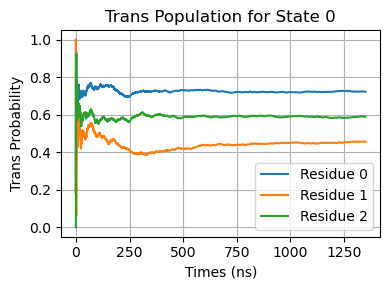

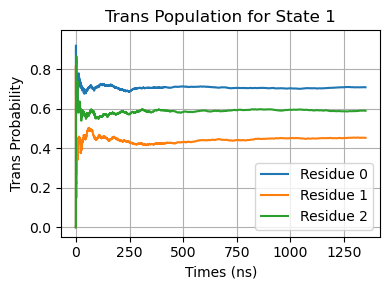

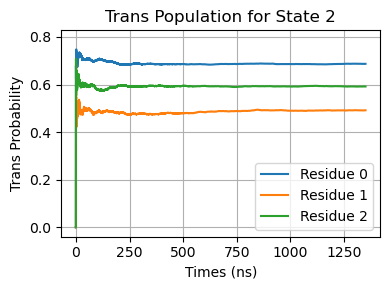

In [9]:
state_num = 3
dt_in_ns = 0.004

for state_index in range(state_num):  # Loop over 6 states
    plt.figure(figsize=(4, 3))
    
    for residue_index in range(3):  # Loop over 3 residues
        y = trans_all_population[state_index, :, residue_index]
        yerr = trans_all_population_err[state_index, :, residue_index]
        x = np.arange(len(y)) * dt_in_ns  # or use actual time values

        plt.plot(x, y, label=f'Residue {residue_index}')
        plt.fill_between(x, y - yerr, y + yerr, alpha=1)

    plt.title(f'Trans Population for State {state_index}')
    plt.xlabel('Times (ns)')
    plt.ylabel('Trans Probability')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


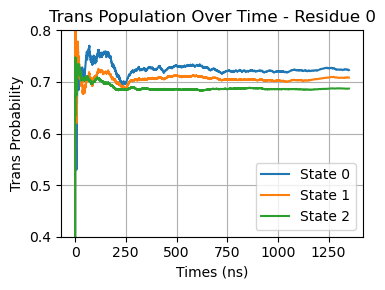

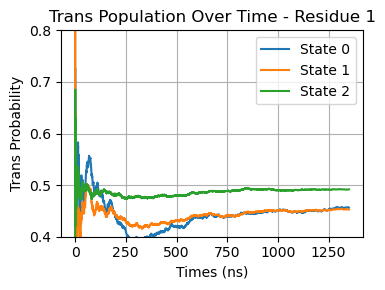

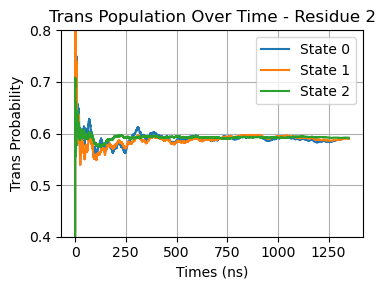

In [18]:
state_num = 3
dt_in_ns = 0.004

for residue_index in range(3):  # 3 residues
    plt.figure(figsize=(4, 3))

    for state_index in range(state_num):  # 6 states
        y = trans_all_population[state_index, :, residue_index]
        yerr = trans_all_population_err[state_index, :, residue_index]
        x = np.arange(len(y)) * dt_in_ns # or use lagtimes or time array if available

        plt.plot(x, y, label=f'State {state_index}')
        plt.fill_between(x, y - yerr, y + yerr, alpha=0.2)

    plt.title(f'Trans Population Over Time - Residue {residue_index}')
    plt.xlabel('Times (ns)')
    plt.ylabel('Trans Probability')
    plt.grid(True)
    plt.ylim(0.4, 0.8)
    plt.legend()
    plt.tight_layout()
    plt.show()


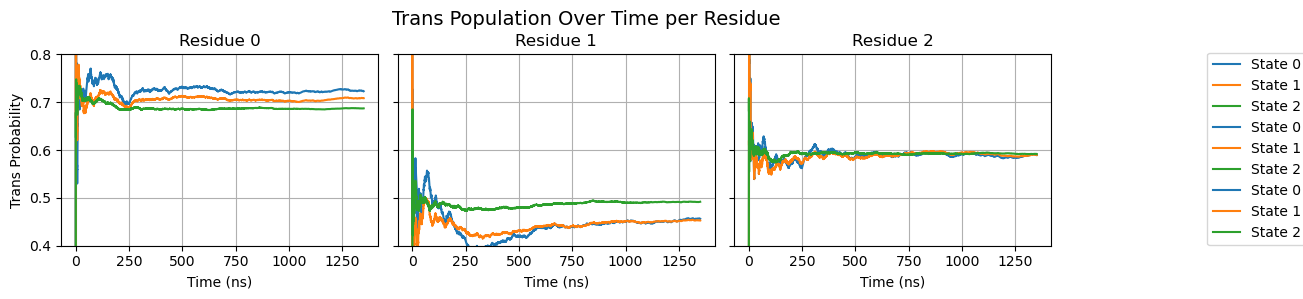

In [19]:
import matplotlib.pyplot as plt
import numpy as np

state_num = 3
dt_in_ns = 0.004

fig, axs = plt.subplots(1, 3, figsize=(12, 3), sharey=True)

for residue_index in range(3):  # 3 residues
    ax = axs[residue_index]

    for state_index in range(state_num):  # 3 states
        y = trans_all_population[state_index, :, residue_index]
        yerr = trans_all_population_err[state_index, :, residue_index]
        x = np.arange(len(y)) * dt_in_ns  # or use lagtimes or time array if available

        ax.plot(x, y, label=f'State {state_index}')
        ax.fill_between(x, y - yerr, y + yerr, alpha=0.2)

    ax.set_title(f'Residue {residue_index}')
    ax.set_xlabel('Time (ns)')
    ax.set_ylim(0.4, 0.8)
    ax.grid(True)
    if residue_index == 0:
        ax.set_ylabel('Trans Probability')

fig.suptitle('Trans Population Over Time per Residue', fontsize=14)
fig.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
fig.tight_layout(rect=[0, 0, 0.9, 0.95])
plt.show()


## Error Over Times

In [20]:
df_stationary_p = pd.read_csv("autocoorel_data/trans_population_at_lagtime.csv")
#print(df_stationary_p)

    
# Pivot the DataFrame to reshape it
pivot_mean = df_stationary_p.pivot(index='state', columns='res', values='mean')
pivot_std = df_stationary_p.pivot(index='state', columns='res', values='std')

# Convert to NumPy arrays
trans_refer_array = pivot_mean.to_numpy()  # shape (6, 3) state, residues 
trans_refer_err_array = pivot_std.to_numpy()  # shape (6, 3)
trans_refer_array.shape
trans_refer_array

array([[0.72255401, 0.45853655, 0.59192364],
       [0.70887749, 0.45355979, 0.59130037],
       [0.68692877, 0.49295564, 0.59105663]])

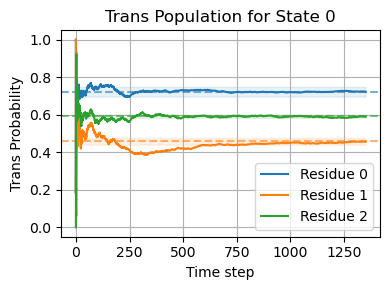

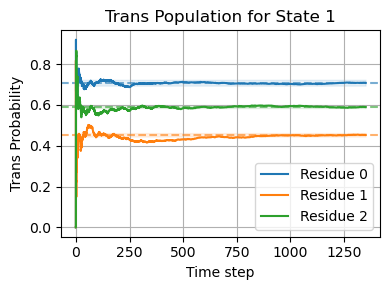

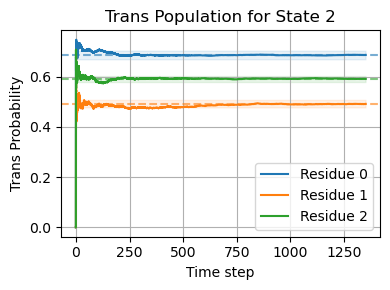

In [21]:
state_num = 3
dt_in_ns = 0.004

for state_index in range(state_num):  # Loop over 6 states
    plt.figure(figsize=(4, 3))
    
    for residue_index in range(3):  # Loop over 3 residues
        y = trans_all_population[state_index, :, residue_index]
        x = np.arange(len(y)) * dt_in_ns# or use actual time values
        # Time-dependent population
        plt.plot(x, y, label=f'Residue {residue_index}')

        # Reference horizontal line
        ref_y = trans_refer_array[state_index, residue_index]
        ref_yerr = trans_refer_err_array[state_index, residue_index]

        plt.axhline(y=ref_y, linestyle='--', color=f'C{residue_index}', alpha=0.6)
        plt.fill_between(x, ref_y - ref_yerr, ref_y + ref_yerr, color=f'C{residue_index}', alpha=0.1)

    plt.title(f'Trans Population for State {state_index}')
    plt.xlabel('Time step')
    plt.ylabel('Trans Probability')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


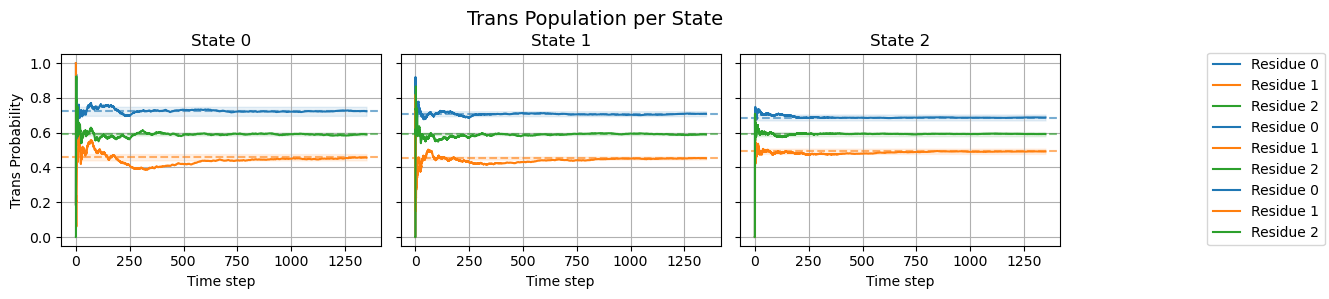

In [22]:
state_num = 3
dt_in_ns = 0.004

fig, axs = plt.subplots(1, 3, figsize=(12, 3), sharey=True)

for state_index in range(state_num):  # Loop over 3 states
    ax = axs[state_index]

    for residue_index in range(3):  # Loop over 3 residues
        y = trans_all_population[state_index, :, residue_index]
        x = np.arange(len(y)) * dt_in_ns# or use actual time values

        # Time-dependent population
        ax.plot(x, y, label=f'Residue {residue_index}')

        # Reference horizontal line with error band
        ref_y = trans_refer_array[state_index, residue_index]
        ref_yerr = trans_refer_err_array[state_index, residue_index]

        ax.axhline(y=ref_y, linestyle='--', color=f'C{residue_index}', alpha=0.6)
        ax.fill_between(x, ref_y - ref_yerr, ref_y + ref_yerr, color=f'C{residue_index}', alpha=0.1)

    ax.set_title(f'State {state_index}')
    ax.set_xlabel('Time step')
    ax.grid(True)
    if state_index == 0:
        ax.set_ylabel('Trans Probability')

fig.suptitle('Trans Population per State', fontsize=14)
fig.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
fig.tight_layout(rect=[0, 0, 0.9, 0.95])
plt.show()


### Plot the ERROR

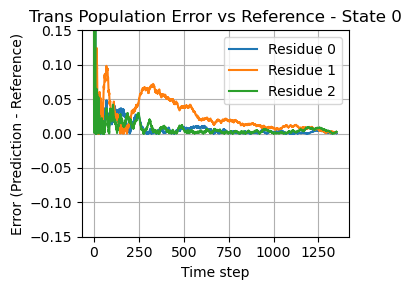

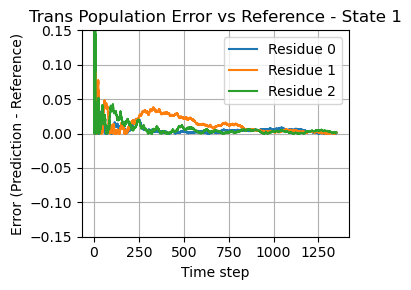

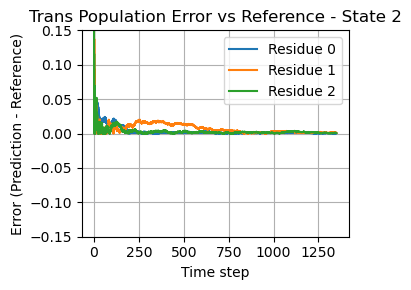

In [23]:
state_num = 3
dt_in_ns = 0.004

errors_all = []
for state_index in range(state_num):  # Loop over 6 states
    plt.figure(figsize=(4, 3))
    x = np.arange(trans_all_population.shape[1])  * dt_in_ns # Time axis, e.g., 60003
    errors = []

    for residue_index in range(3):  # Loop over 3 residues
        error = trans_all_population[state_index, :, residue_index] - trans_refer_array[state_index, residue_index]
        error = np.abs(error) # Take the abs value
        errors.append(error)
        plt.plot(x, error, label=f'Residue {residue_index}')

    errors_all.append(errors)
    
    plt.title(f'Trans Population Error vs Reference - State {state_index}')
    plt.xlabel('Time step')
    plt.ylabel('Error (Prediction - Reference)')
    plt.grid(True)
    plt.legend()
    plt.ylim(-0.15, 0.15)
    plt.tight_layout()
    plt.show()


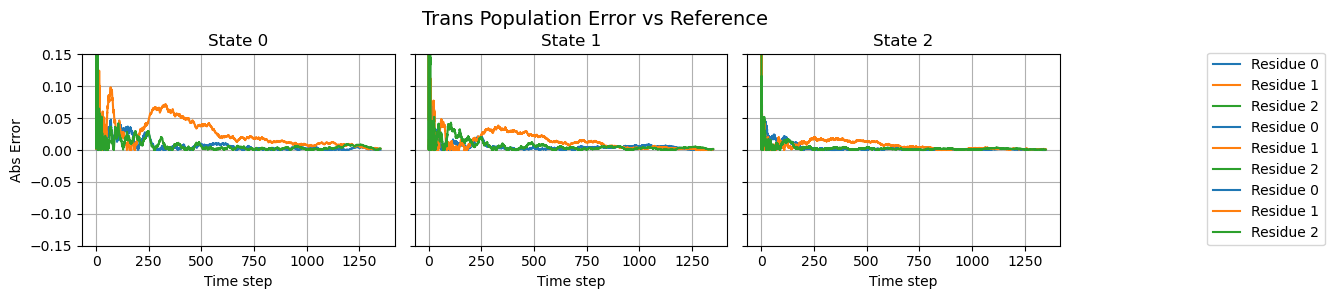

In [16]:

state_num = 3
errors_all = []
dt_in_ns = 0.004

fig, axs = plt.subplots(1, 3, figsize=(12, 3), sharey=True)
x = np.arange(trans_all_population.shape[1]) * dt_in_ns # Time axis, e.g., 60003
for state_index in range(state_num):  # Loop over 3 states
    ax = axs[state_index]
    errors = []

    for residue_index in range(3):  # Loop over 3 residues
        error = trans_all_population[state_index, :, residue_index] - trans_refer_array[state_index, residue_index]
        error = np.abs(error)
        errors.append(error)

        ax.plot(x, error, label=f'Residue {residue_index}')

    errors_all.append(errors)

    ax.set_title(f'State {state_index}')
    ax.set_xlabel('Time step')
    ax.set_ylim(-0.15, 0.15)
    ax.grid(True)
    if state_index == 0:
        ax.set_ylabel('Abs Error')

fig.suptitle('Trans Population Error vs Reference', fontsize=14)
fig.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
fig.tight_layout(rect=[0, 0, 0.9, 0.95])
plt.show()


In [17]:
errors_all = np.array(errors_all)
print(errors_all.shape)
errors_result = [errors_all]

os.makedirs('population_data', exist_ok=True)

data_instance = Data(errors_result)
data_instance.save("population_data/error_res.pkl")

(3, 3, 337514)
